## EDA RFM Analysis with Kmeans Cluster

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = 'browser'  # Opens the figure in your default web browser


In [2]:
# Data reading
sale=pd.read_csv(r"data\sale_data.csv",encoding='iso-8859-1')
# Convert the 'InvoiceDate' column to datetime format, specifying the date format
sale['InvoiceDate'] = pd.to_datetime(sale['InvoiceDate'], format='%d-%m-%Y %H:%M', errors='coerce')
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
sale_data=sale.copy()

In [4]:
sale_data[sale_data['Customer ID'].isna()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [5]:
sale_data[sale_data['Quantity']<0].head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [6]:
sale_data['Invoice']=sale_data['Invoice'].astype(str)
sale_data[sale_data['Invoice'].str.match("^\\d{6}$")==False].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [7]:
sale_data['Invoice'].str.replace('[0-9]','',regex=True).unique()

array(['', 'C', 'A'], dtype=object)

In [8]:
sale_data[sale_data['Invoice'].str.startswith('A')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [9]:
cleaned_df=sale_data.copy()

In [10]:
cleaned_df['Invoice']=cleaned_df['Invoice'].astype("str")
mask=(
    cleaned_df['Invoice'].str.match('^\\d{6}$')==True
)
cleaned_df=cleaned_df[mask]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [11]:
cleaned_df['StockCode']=cleaned_df['StockCode'].astype("str")
mask=(
    (cleaned_df['StockCode'].str.match('^\\d{5}$')==True)|
    (cleaned_df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$')==True)|
    (cleaned_df['StockCode'].str.match('^PADS$')==True)    
)
cleaned_df=cleaned_df[mask]
cleaned_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
cleaned_df.dropna(subset=['Customer ID'],inplace=True)
cleaned_df.describe()

C:\Users\yohannanpc\AppData\Local\Temp\ipykernel_17712\280422381.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Quantity,InvoiceDate,Price,Customer ID
count,396374.000000,396374,396374.000000,396374.000000
mean,13.046353,2011-07-11 00:04:48.847805440,2.867954,15301.603824
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16803.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,180.732689,NaN,4.264554,1709.976485


In [13]:
cleaned_df=cleaned_df[cleaned_df["Price"]>0]
cleaned_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [14]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,396340.000000,396340,396340.000000,396340.000000
mean,13.012456,2011-07-11 00:04:40.164908544,2.868200,15301.689070
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16803.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,179.640568,NaN,4.264654,1709.957487


In [15]:
droped_data=1-(len(cleaned_df)/len(sale_data))

In [16]:
f"droped {np.round(droped_data,2)*100}% data"

'droped 27.0% data'

# Feature Engineering

In [17]:
cleaned_df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [18]:
cleaned_df['Sale_Value']=cleaned_df.Quantity*cleaned_df.Price

In [19]:
# RFM Grouping
aggregated_df=cleaned_df.groupby(by='Customer ID',as_index=False).agg(
    Monetary=("Sale_Value","sum"),
    Frequency=("Invoice","nunique"),
    LastInvoiceDate=("InvoiceDate","max")
)
aggregated_df.head()

,Customer ID,Monetary,Frequency,LastInvoiceDate
0,12346.0,77183.60,1,2011-01-18 10:01:00
1,12347.0,4310.00,7,2011-12-07 15:52:00
2,12348.0,1437.24,4,2011-09-25 13:13:00
3,12349.0,1457.55,1,2011-11-21 09:51:00
4,12350.0,294.40,1,2011-02-02 16:01:00


In [20]:
# findout last date in saledata
max_date=aggregated_df.LastInvoiceDate.max()
max_date

Timestamp('2011-12-09 12:50:00')

In [21]:
# Recency calculation
aggregated_df['Recency']=(max_date-aggregated_df['LastInvoiceDate']).dt.days

In [22]:
aggregated_df.head()

,Customer ID,Monetary,Frequency,LastInvoiceDate,Recency
0,12346.0,77183.60,1,2011-01-18 10:01:00,325
1,12347.0,4310.00,7,2011-12-07 15:52:00,1
2,12348.0,1437.24,4,2011-09-25 13:13:00,74
3,12349.0,1457.55,1,2011-11-21 09:51:00,18
4,12350.0,294.40,1,2011-02-02 16:01:00,309


In [23]:
RFM_colums=list(["Monetary","Frequency","Recency"])
RFM_colums

['Monetary', 'Frequency', 'Recency']

In [24]:
RFM_data=aggregated_df[RFM_colums]
RFM_data

,Monetary,Frequency,Recency
0,77183.60,1,325
1,4310.00,7,1
2,1437.24,4,74
3,1457.55,1,18
4,294.40,1,309
...,...,...,...
4329,180.60,1,277
4330,80.82,1,180
4331,178.05,2,7
4332,2088.93,16,3


In [25]:
colors = ['skyblue', 'lightgreen', 'salmon']

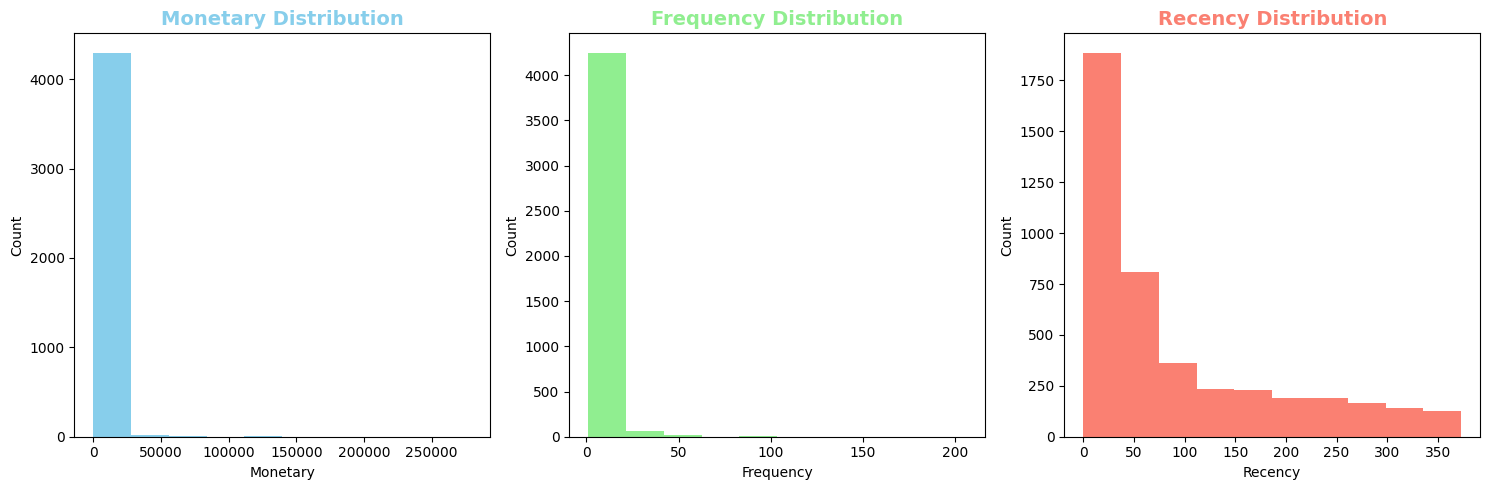

In [26]:
# check the distribution of the data in histogram
plt.figure(figsize=(15,5))
for index, name in enumerate(RFM_colums):    
    plt.subplot(1,3,index+1)
    plt.hist(RFM_data[name],color=colors[index % len(colors)])
    plt.title(f"{name} Distribution",color=colors[index %len(colors)],fontweight='bold',fontsize=14)
    plt.xlabel(f"{name}")
    plt.ylabel(f"Count")
plt.tight_layout()
plt.show()
    


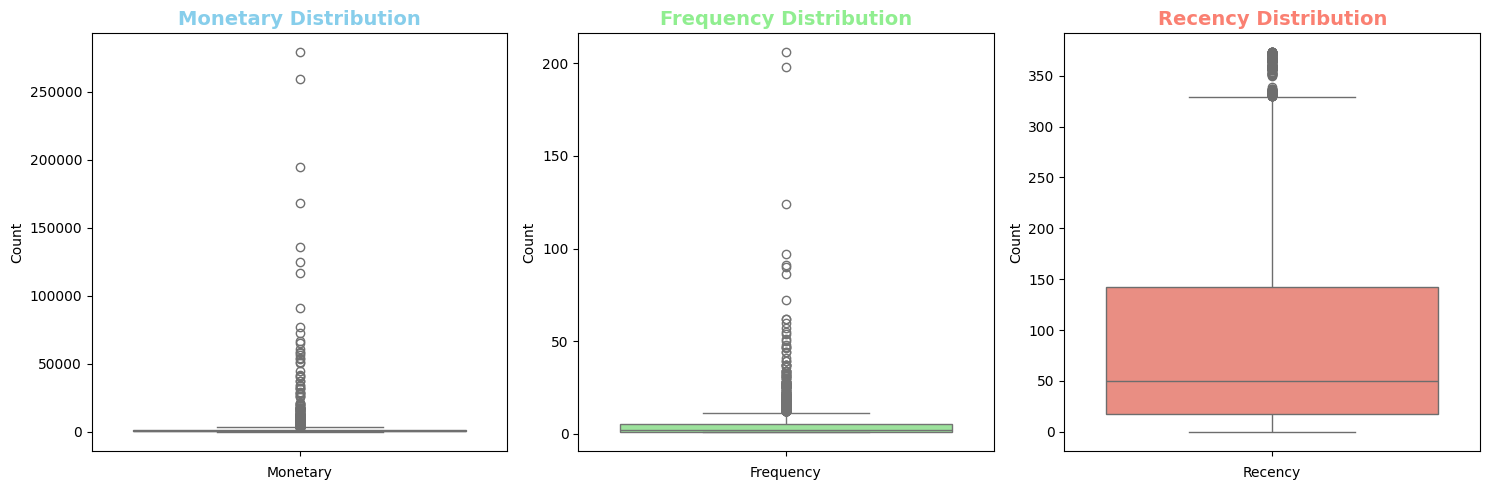

In [27]:
# check the outlier of the data in boxplot
plt.figure(figsize=(15,5))
for index, name in enumerate(RFM_colums):    
    plt.subplot(1,3,index+1)
    sns.boxplot(RFM_data[name],color=colors[index % len(colors)])
    plt.title(f"{name} Distribution",color=colors[index %len(colors)],fontweight='bold',fontsize=14)
    plt.xlabel(f"{name}")
    plt.ylabel(f"Count")
plt.tight_layout()
plt.show()

In [28]:
# non-outlier data separation
def non_outlier_calculation(RFM_data):
    limits=[]
    
    for i in RFM_data:
        if i!="Recency":
            Q1=RFM_data[i].quantile(0.25)
            Q3=RFM_data[i].quantile(0.75)
            IQR=Q3-Q1
            lower_bound=Q1-(1.5*IQR)
            upper_bound=Q3+(1.5*IQR)
            limits.append({"RFM_Params":i,"Lower_Bound":lower_bound,"Upper_Bound":upper_bound,"IQR":IQR})
    quantile_cal=pd.DataFrame(limits)
    Monetary_L_Bound=quantile_cal.loc[quantile_cal['RFM_Params']=='Monetary','Lower_Bound']
    Monetary_U_Bound=quantile_cal.loc[quantile_cal['RFM_Params']=='Monetary','Upper_Bound']
    
    Frequency_L_Bound=quantile_cal.loc[quantile_cal['RFM_Params']=='Frequency','Lower_Bound']
    Frequency_U_Bound=quantile_cal.loc[quantile_cal['RFM_Params']=='Frequency','Upper_Bound']
    
    M_Outlier_DF=RFM_data[(RFM_data['Monetary']<Monetary_L_Bound[0])|(RFM_data['Monetary']>Monetary_U_Bound[0])]
    F_Outlier_DF=RFM_data[(RFM_data['Frequency']<Frequency_L_Bound[1])|(RFM_data['Frequency']>Frequency_U_Bound[1])]
    Non_Outlier_Data=RFM_data[(~RFM_data.index.isin(M_Outlier_DF.index))&(~RFM_data.index.isin(F_Outlier_DF.index))]
    return Non_Outlier_Data,M_Outlier_DF,F_Outlier_DF


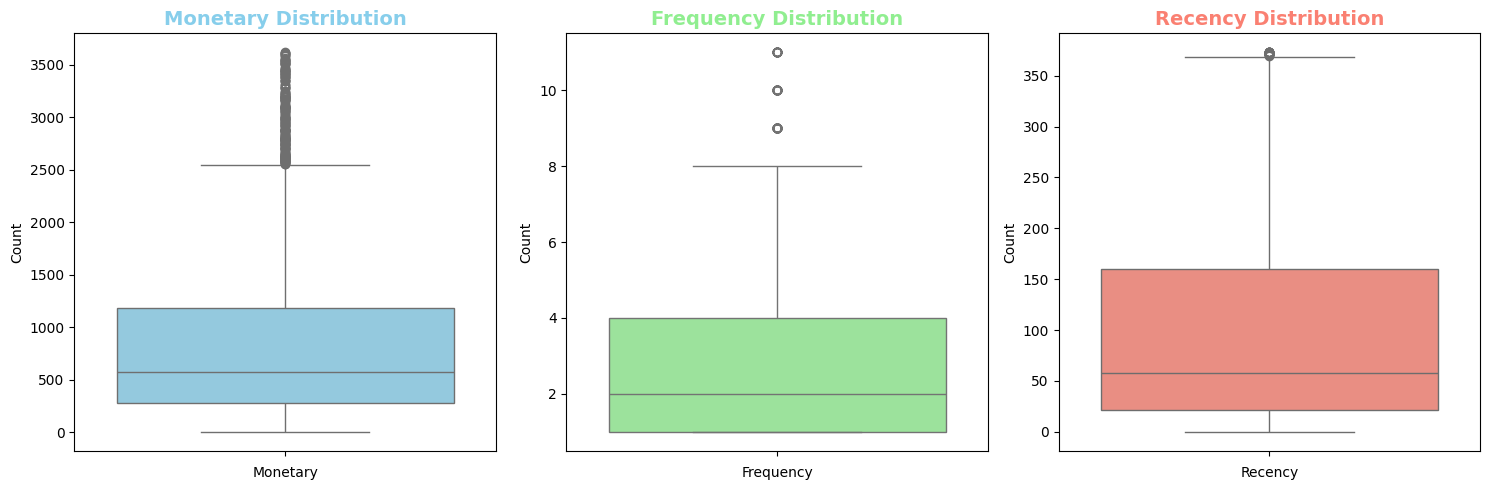

In [29]:
# check Non-outlier data in box plot
Non_Outlier_Data,_,_=non_outlier_calculation(RFM_data)
plt.figure(figsize=(15,5))
for index, name in enumerate(RFM_colums):    
    plt.subplot(1,3,index+1)
    sns.boxplot(Non_Outlier_Data[name],color=colors[index % len(colors)])
    plt.title(f"{name} Distribution",color=colors[index %len(colors)],fontweight='bold',fontsize=14)
    plt.xlabel(f"{name}")
    plt.ylabel(f"Count")
plt.tight_layout()
plt.show()

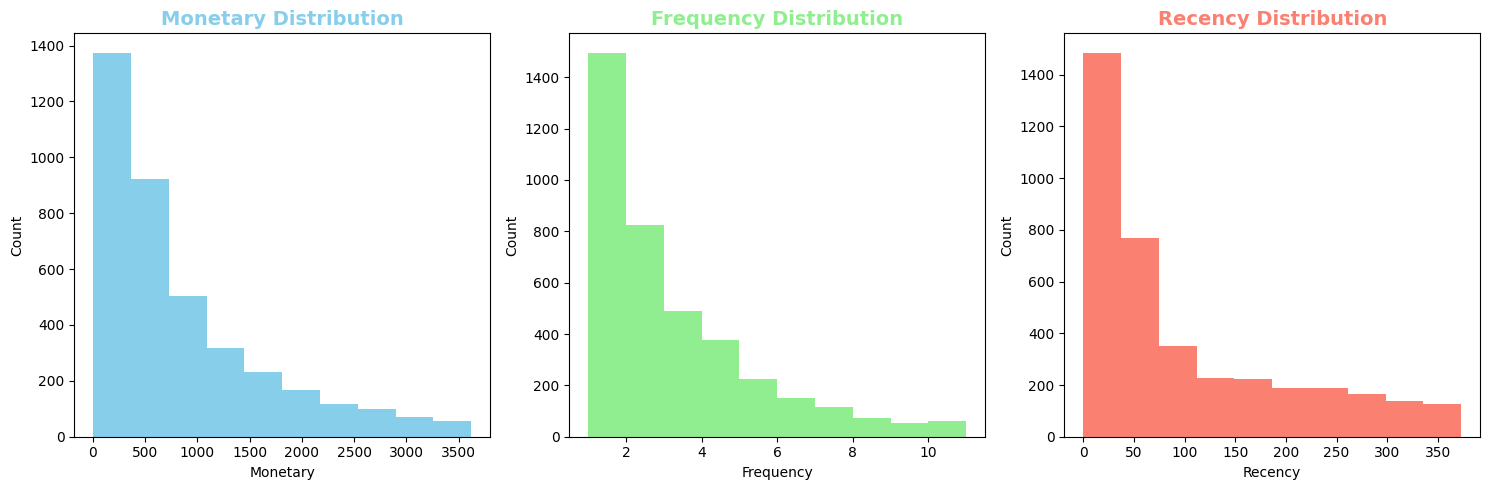

In [30]:
# check non-outlier data distribution in histogram
plt.figure(figsize=(15,5))
for index, name in enumerate(RFM_colums):    
    plt.subplot(1,3,index+1)
    plt.hist(Non_Outlier_Data[name],color=colors[index % len(colors)])
    plt.title(f"{name} Distribution",color=colors[index %len(colors)],fontweight='bold',fontsize=14)
    plt.xlabel(f"{name}")
    plt.ylabel(f"Count")
plt.tight_layout()
plt.show()

In [31]:
# feature scaling
scalar=StandardScaler()
scaled_data=scalar.fit_transform(Non_Outlier_Data)
scaled_data=pd.DataFrame(scaled_data,columns=['Monetary','Frequency','Recency'],index=Non_Outlier_Data.index)
scaled_data

,Monetary,Frequency,Recency
2,0.734326,0.574252,-0.254717
3,0.759889,-0.809612,-0.804526
4,-0.704104,-0.809612,2.052518
5,0.669505,1.958116,-0.637620
6,-0.962630,-0.809612,1.011808
...,...,...,...
4328,-0.855771,-0.809612,-0.264535
4329,-0.847338,-0.809612,1.738342
4330,-0.972926,-0.809612,0.785993
4331,-0.850547,-0.348324,-0.912525


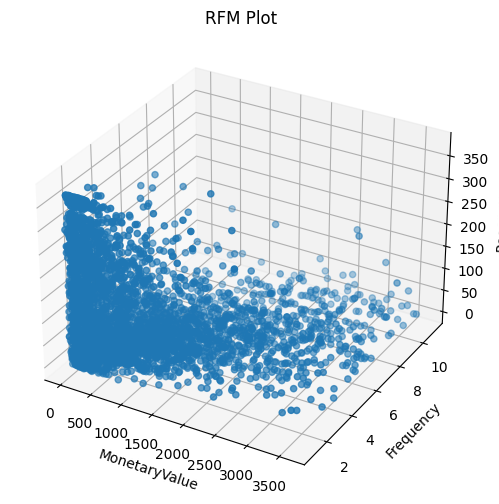

In [32]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(projection='3d')
scatter=ax.scatter(Non_Outlier_Data['Monetary'],Non_Outlier_Data['Frequency'],Non_Outlier_Data['Recency'])
ax.set_xlabel("MonetaryValue")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("RFM Plot")
plt.show()

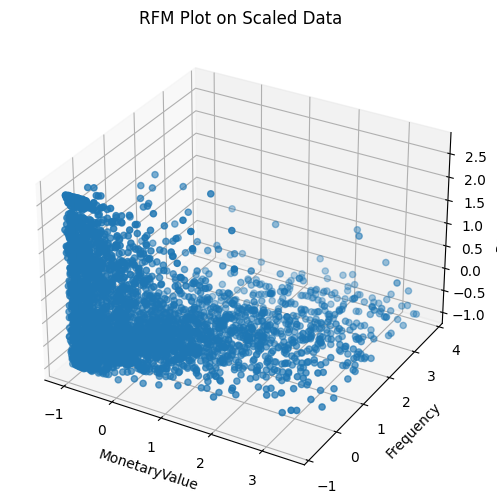

In [33]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(projection='3d')
scatter=ax.scatter(scaled_data['Monetary'],scaled_data['Frequency'],scaled_data['Recency'])
ax.set_xlabel("MonetaryValue")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("RFM Plot on Scaled Data")
plt.show()

d:\Customer_Segmentation_V02\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

d:\Customer_Segmentation_V02\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

d:\Customer_Segmentation_V02\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

d:\Customer_Segmentation_V02\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

d:\Customer_Segmentation_V02\venv\lib\site-packages\sklearn\cluster\_kmeans.

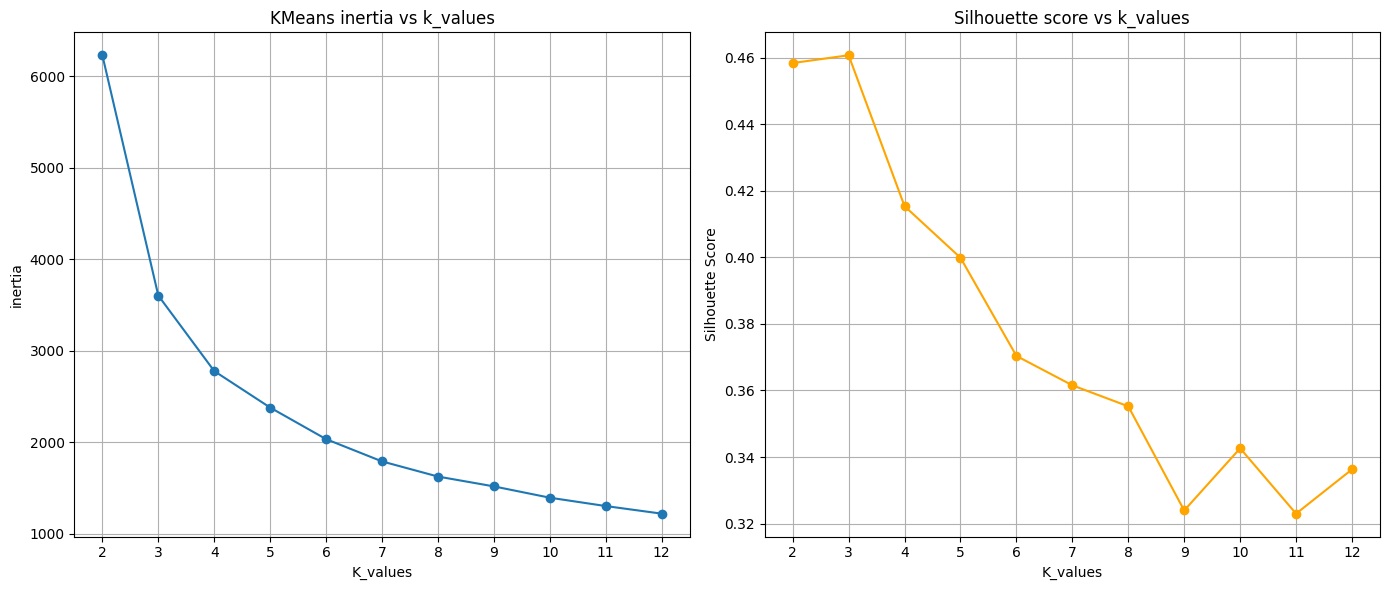

In [34]:
# kmeans inertia and silhouette score vs K_values
max_k=12
inertia=[]
silhouette_scores=[]
k_values=range(2,max_k+1)
for k in k_values:
    kmeans=KMeans(n_clusters=k,max_iter=1000,random_state=42)
    cluster_label=kmeans.fit_predict(scaled_data)
    sil_score=silhouette_score(scaled_data,cluster_label)
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(k_values,inertia,marker='o')
plt.title("KMeans inertia vs k_values" )
plt.xlabel("K_values")
plt.ylabel("inertia")
plt.xticks(k_values)
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(k_values,silhouette_scores,marker='o',color='orange')
plt.title("Silhouette score vs k_values" )
plt.xlabel("K_values")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
kmeans=KMeans(n_clusters=4,random_state=42,max_iter=1000)
cluster_label=kmeans.fit_predict(scaled_data)
cluster_label

d:\Customer_Segmentation_V02\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([3, 0, 1, ..., 1, 0, 3])

In [36]:
Non_Outlier_Data['Cluster']=cluster_label
Non_Outlier_Data.head()

C:\Users\yohannanpc\AppData\Local\Temp\ipykernel_17712\3264758030.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Monetary,Frequency,Recency,Cluster
2,1437.24,4,74,3
3,1457.55,1,18,0
4,294.40,1,309,1
5,1385.74,7,35,2
6,89.00,1,203,1


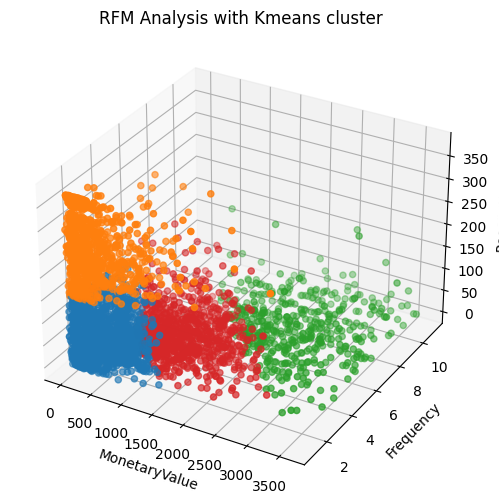

In [37]:
# non-outlier clustered data in scatterplot
cluster_colors={
    0:'#1f77b4',
    1:'#ff7f0e',
    2:'#2ca02c',
    3:'#d62728'}
colors=Non_Outlier_Data['Cluster'].map(cluster_colors)
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(projection='3d')
scatter=ax.scatter(Non_Outlier_Data['Monetary'],Non_Outlier_Data['Frequency'],Non_Outlier_Data['Recency'],c=colors)
ax.set_xlabel("MonetaryValue")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("RFM Analysis with Kmeans cluster")
plt.show()

In [49]:
fig_3d = px.scatter_3d(
    Non_Outlier_Data,
    x=Non_Outlier_Data['Monetary'],
    y=Non_Outlier_Data['Frequency'],
    z=Non_Outlier_Data['Recency'],
    color=colors
)

# Reduce the marker size
fig_3d.update_traces(marker=dict(size=5))  # Adjust size as needed

# Set the layout
fig_3d.update_layout(margin=dict(l=20, r=20, t=20, b=20))

# Show the figure
fig_3d.show()


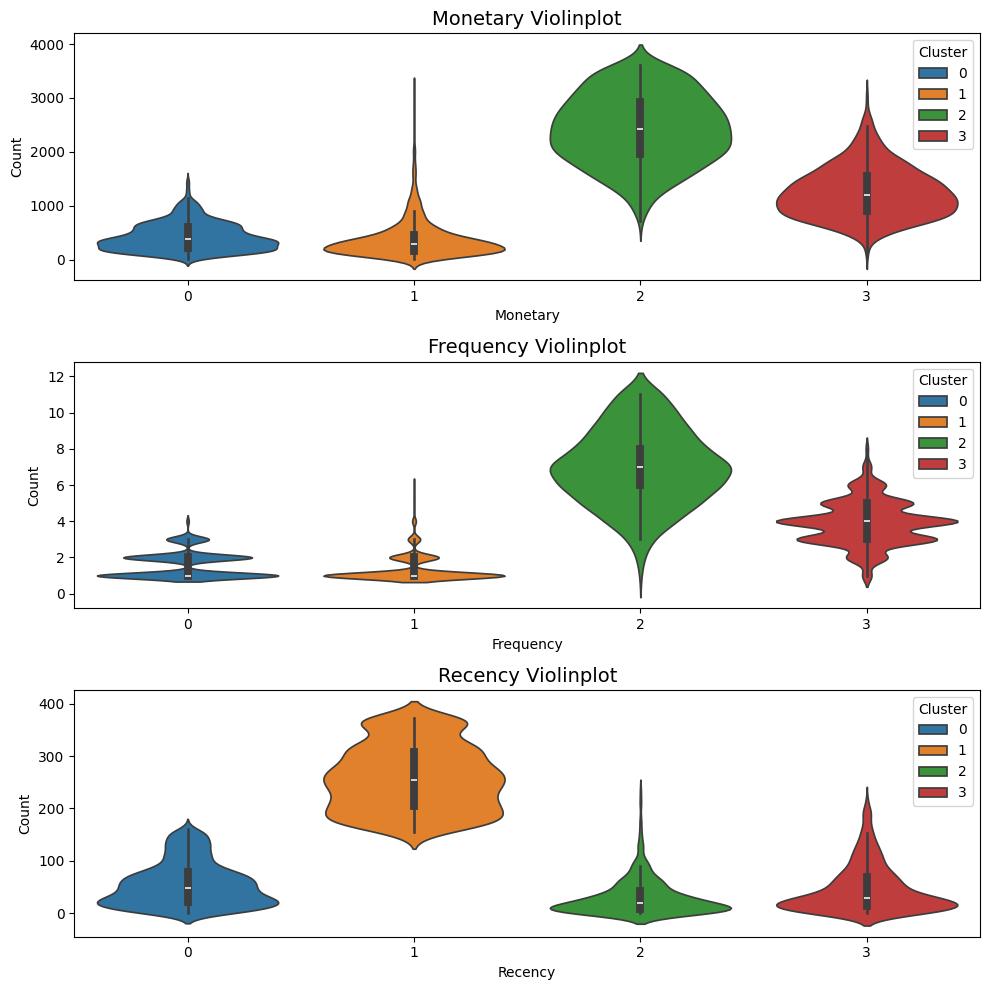

In [39]:
# non-outlier clustered data in violin plot
plt.figure(figsize=(10,10))
for index,name in enumerate(RFM_colums):
    plt.subplot(3,1,index+1)
    sns.violinplot(x=Non_Outlier_Data['Cluster'],y=Non_Outlier_Data[name],palette=cluster_colors,hue=Non_Outlier_Data['Cluster'])
    plt.title(f"{name} Violinplot",fontsize=14)
    plt.xlabel(f'{name}')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [40]:
# outlier data separation
_,M_Outlier_DF,F_Outlier_DF=non_outlier_calculation(RFM_data)
Overlap_Outlier_Index=M_Outlier_DF.index.intersection(F_Outlier_DF.index)
M_only_outliers=M_Outlier_DF.drop(Overlap_Outlier_Index)
F_only_outliers=F_Outlier_DF.drop(Overlap_Outlier_Index)
M_F_overlap_DF=M_Outlier_DF.loc[Overlap_Outlier_Index]

In [41]:
# Assigning cluster numbers to identify outlier data
M_only_outliers['Cluster']=-1
F_only_outliers['Cluster']=-2
M_F_overlap_DF['Cluster']=-3
outlier_DF=pd.concat([M_only_outliers,F_only_outliers,M_F_overlap_DF])
outlier_DF.head()


,Monetary,Frequency,Recency,Cluster
0,77183.60,1,325,-1
1,4310.00,7,1,-1
10,6207.67,1,32,-1
12,6372.58,4,57,-1
15,4737.23,10,2,-1


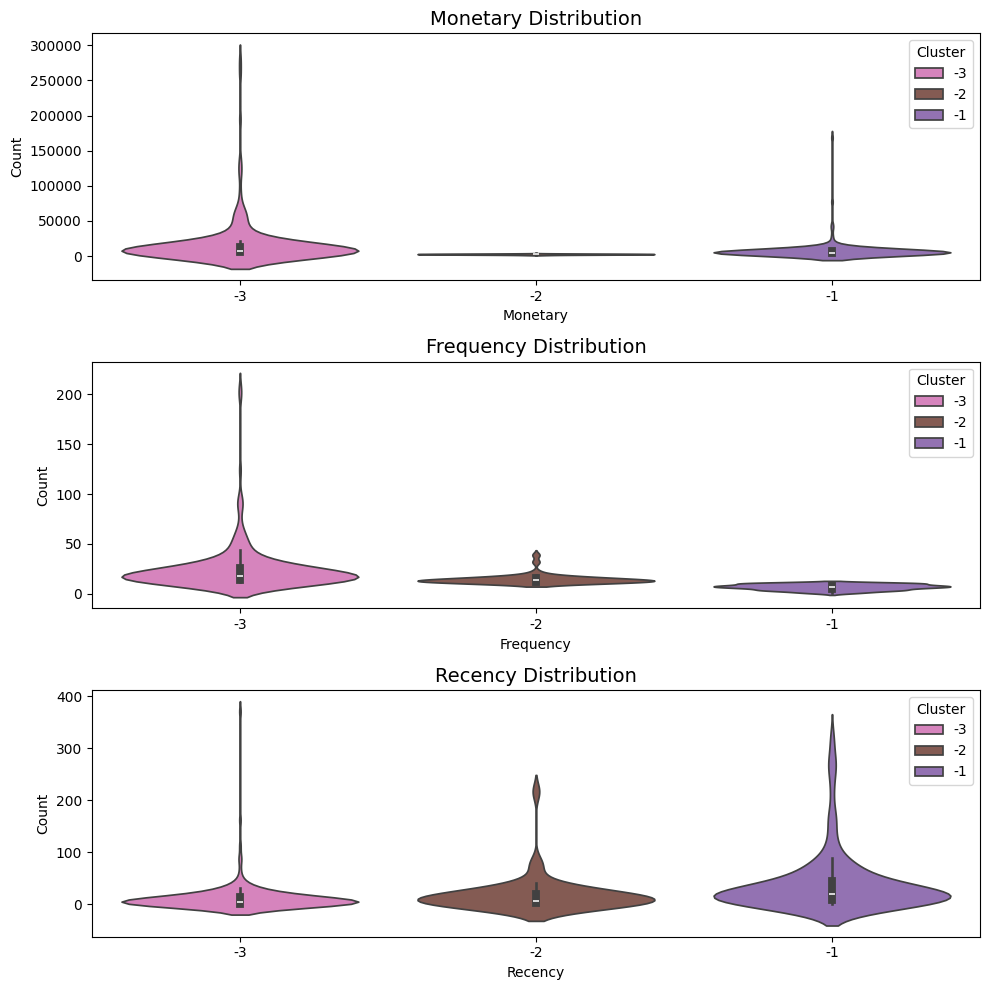

In [42]:
cluster_colors={
    -1:'#9467bd',
    -2:'#8c564b',
    -3:'#e377c2'}
plt.figure(figsize=(10,10))
for index,name in enumerate(RFM_colums):
    plt.subplot(3,1,index+1)
    sns.violinplot(x=outlier_DF['Cluster'],y=outlier_DF[name],palette=cluster_colors,hue=outlier_DF['Cluster'])
    plt.xlabel(f"{name}")
    plt.ylabel("Count")
    plt.title(f"{name} Distribution",fontsize=14)
plt.tight_layout()
plt.show()

In [43]:
cluster_name={
    0:"Recent Low Val",
    1:"Inactive",
    2:"Premium",
    3:"Moderate",
    -1:"Gold",
    -2:"Platinum",
    -3:"Super Platinum"
}
# outlier and nonoutlier data merging
full_cluster_df=pd.concat([Non_Outlier_Data,outlier_DF])
full_cluster_df

,Monetary,Frequency,Recency,Cluster
2,1437.24,4,74,3
3,1457.55,1,18,0
4,294.40,1,309,1
5,1385.74,7,35,2
6,89.00,1,203,1
...,...,...,...,...
4248,7561.68,20,14,-3
4268,5425.56,17,3,-3
4287,6484.54,14,4,-3
4289,5509.12,12,2,-3


In [44]:
full_cluster_df['ClusterLabel']=full_cluster_df['Cluster'].map(cluster_name)
full_cluster_df


,Monetary,Frequency,Recency,Cluster,ClusterLabel
2,1437.24,4,74,3,Moderate
3,1457.55,1,18,0,Recent Low Val
4,294.40,1,309,1,Inactive
5,1385.74,7,35,2,Premium
6,89.00,1,203,1,Inactive
...,...,...,...,...,...
4248,7561.68,20,14,-3,Super Platinum
4268,5425.56,17,3,-3,Super Platinum
4287,6484.54,14,4,-3,Super Platinum
4289,5509.12,12,2,-3,Super Platinum


In [45]:
full_cluster_df['Monetary_Val']=full_cluster_df['Monetary']/100
cluster_counts=full_cluster_df['ClusterLabel'].value_counts()
feature_means=full_cluster_df.groupby(by='ClusterLabel')[['Monetary_Val','Frequency','Recency']].mean()
cluster_counts.index

Index(['Recent Low Val', 'Inactive', 'Moderate', 'Premium', 'Super Platinum',
       'Gold', 'Platinum'],
      dtype='object', name='ClusterLabel')

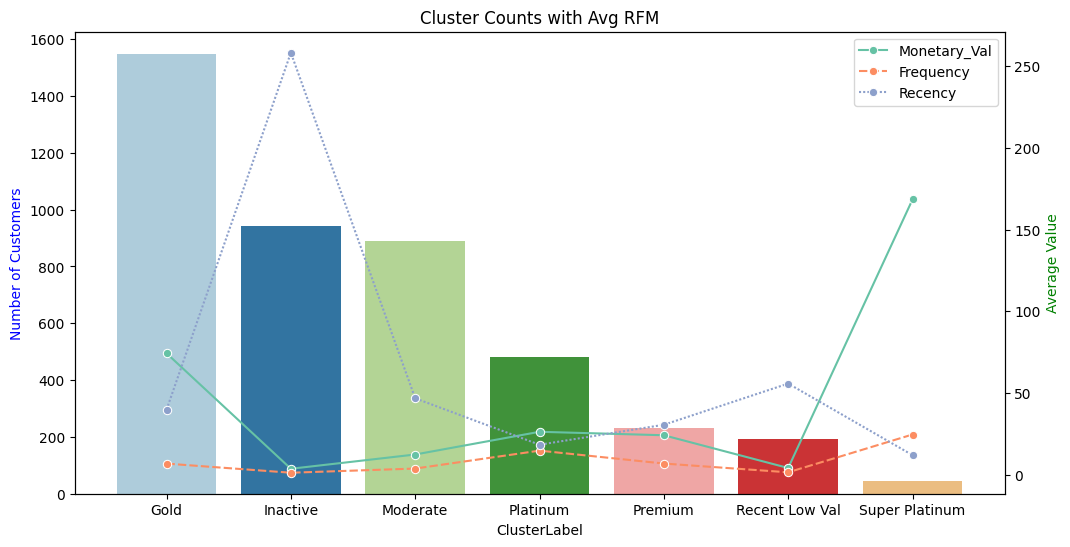

In [46]:
fig,ax1=plt.subplots(figsize=(12,6))
sns.barplot(x=cluster_counts.index,y=cluster_counts.values,ax=ax1,palette='Paired',hue=cluster_counts.index)
ax1.set_title("Cluster Counts with Avg RFM")
ax1.set_ylabel("Number of Customers",color='b')
ax2=ax1.twinx()
sns.lineplot(data=feature_means,ax=ax2,palette='Set2',marker='o')
ax2.set_ylabel('Average Value',color='g')
plt.show()